# SQL simple language model checker

In [1]:
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import random
from multiprocessing.pool import ThreadPool
import os
from matplotlib import pyplot as plt

## Sample generation

In [2]:
cols = ['COL_ZERO', 'COL_TWO', 'COL_THREE', 'COL_FOUR', 'COL_FIVE', 'COL_SIX', 'COL_SEVEN']
frm = 'FROM'

literals = ['STRING', 'NUM']
concats = ['AND', 'OR']

sql_s_vocabulary = ['SELECT'] + cols + [',',
    'FROM',
    'TABLE_NAME',
    'WHERE',
    'IN',
    'EXISTS',
    # 'JOIN', # joins introduce a lot of complexity, will try without it and if it goes well add it later
    'AND',
    'OR',
    'LIKE',
    '(',
    'STRING',
    'NUM',
    ')',
    'LIMIT',
    'EMPTY'
  ]

sqlSDict = {el:idx for idx,el in enumerate(sql_s_vocabulary)}

global_recursive_counter = 0

In [3]:
def select_col_not_in(in_cols):
  cc = [it for it in cols if it not in in_cols]
  return random.choice(cc)

def gen_core():
  q = []
  q.append('SELECT')
  c = cols[random.randint(0, len(cols)-1)]
  output_cols = [c]
  q.append(c)
  temp_cols = [it for it in cols if it not in output_cols]
  for cc in random.sample(temp_cols, k=random.randint(0, len(temp_cols)-1)):
    q.append(',')
    q.append(cc)
    output_cols.append(cc)
  q.append(frm)
  q.append('TABLE_NAME')
  return q, output_cols

def gen_IN_conditions(in_cols):
  if random.random() < 0.5:
    val_type = 'STRING'
  else:
    val_type = 'NUM'
  q = []
  q.append(random.choice(in_cols))
  q.append('IN')
  q.append('(')
  q.append(val_type)
  for _ in range(random.randint(0, 16)):
    q.append(',')
    q.append(val_type)
  q.append(')')
  return q


def gen_EXISTS_conditions(in_cols):
  global global_recursive_counter
  global_recursive_counter += 1
  if global_recursive_counter > 8:
    return gen_LIKE_conditions(in_cols)
  q = []
  q.append('EXISTS')
  q.append('(')
  q.append('SELECT')
  q.append(random.choice(in_cols))
  q.append(frm)
  q.append('TABLE_NAME')
  q.append('WHERE')
  q += gen_condition(in_cols)
  q.append(')')
  global_recursive_counter = 0
  return q


def gen_LIKE_conditions(in_cols):
  q = []
  q.append(random.choice(in_cols))
  q.append('LIKE')
  q.append('STRING')
  return q


def gen_condition(in_cols):
  possible_conditions = [[0.1, gen_IN_conditions], [0.11, gen_LIKE_conditions], [1.0, gen_EXISTS_conditions]]
  rnJesus = random.random()
  for condition in possible_conditions:
    if rnJesus < condition[0]:
      return condition[1](in_cols)


def gen_conditions(in_cols):
  q = []

  q.append('WHERE')
  q += gen_condition(in_cols)
  return q


def sql_simple_gen_sample(max_len_of_samples=None):
  q, used_cols = gen_core()
  q += gen_conditions(used_cols)
  query = [sqlSDict[it] for it in q]
  not_filled_query = [sqlSDict[it] for it in q]
  if max_len_of_samples is not None:
    empty_values = [sqlSDict['EMPTY'] for _ in range(max_len_of_samples - len(query))]
    query += empty_values

  return query, not_filled_query


def sql_simple_generate_samples(num_of_samples, max_len_of_samples):
  return [sql_simple_gen_sample(max_len_of_samples) for _ in range(num_of_samples)]


def check_max_length():
  lens = [len(sql_simple_gen_sample()) for _ in range(1000)]
  return max(lens)

def sql_simple_decode_sample(sample):
  return [sql_s_vocabulary[int(v + 0.5)] for v in sample]


def sql_simple_decode_sample_into_text(sample):
  return " ".join([sql_s_vocabulary[int(v + 0.5)] for v in sample])

## Files management

In [4]:
def prepare_record(parsed_file):
  parsed = np.loadtxt(parsed_file, dtype=float, converters=float)
  return parsed

def load_dataset(parsed_dir, max_size=None) -> list:
  parsed_files = sorted(os.listdir(parsed_dir))
  if max_size:
    parsed_files = parsed_files[:max_size]

  with ThreadPool() as pool:
    parsed_files = pool.map(lambda f: f"{parsed_dir}{f}", parsed_files)
    files = list(parsed_files)

  with ThreadPool() as pool:
  #   # pool.map guaranteese to preserve order
  #   # pool.map 'consumes' mapping created in previous with block
  #   # map() function returns a generator that is exhausted after is it used
    return [np.array(pool.map(lambda file: prepare_record(file), files)), files]

In [5]:
def resolve_normalization(compute, tokens_capacity, file, dataset):
    if compute:
        layer = keras.layers.Normalization()
        layer.adapt(dataset)
        w = layer.get_weights()
        w = np.asarray(w[:-1])
        np.save(file, w)
        print("adaptet normalizer")
    else:
        n_w = np.load(file, allow_pickle=True)
        layer = keras.layers.Normalization(mean=n_w[0], variance=n_w[1])
        print("loaded normalizer")
    layer.build((tokens_capacity))
    return layer

## Scaling

In [6]:
def scale_dataset_down(dataset, dic_size):
    l = lambda x: (x / (dic_size - 1))
    return np.array(list(map(l, dataset)))

def scale_dataset(dataframe, dic_size):
    l = lambda x: (x) * (dic_size - 1)
    return np.array(list(map(l, dataframe)))

## Network

In [7]:
def sinusoidal_embedding(x, embedding_min_frequency, embedding_max_frequency, embedding_dims):
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims //2,
        )
    )
    
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=2
    )
    return embeddings

In [8]:
def get_network(tokens_capacity, widths, block_depth, embedding_min_frequency, embedding_max_frequency, embedding_dims):
    noisy_images = keras.Input(shape=(tokens_capacity))
    noise_variances = keras.Input(shape=(1,1))

    emb = lambda x: sinusoidal_embedding(x, embedding_min_frequency, embedding_max_frequency, embedding_dims)
    e = layers.Lambda(emb)(noise_variances)
    e = layers.UpSampling1D(tokens_capacity)(e)

    x = layers.Reshape((tokens_capacity, 1))(noisy_images)
    x = layers.Conv1D(widths[0], kernel_size=1)(x)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv1D(1, kernel_size=1, kernel_initializer="zeros")(x)
    x = layers.Flatten()(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")
    

def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[2]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv1D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv1D(width, kernel_size=3, padding="same", activation=keras.activations.swish)(x)
        x = layers.Conv1D(width, kernel_size=3, padding="same", activation=keras.activations.swish)(x)
        x = layers.Add()([x, residual])
        return x

    return apply

def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling1D(pool_size=2, )(x)
        return x

    return apply

def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling1D(size=2)(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

## Model

In [9]:

class DiffusionModel(keras.Model):
    def __init__(
      self, tokens_capacity, dictionary_size, network,
      max_signal_rate, min_signal_rate, normalizer
    ):
        super().__init__()

        self.tokens_capacity = tokens_capacity
        self.dictionary_size = dictionary_size
        self.network = network
        self.max_signal_rate = max_signal_rate
        self.min_signal_rate = min_signal_rate
        self.normalizer = normalizer # shouldn't have axis=None cause normalization will be then strongly affected by mostly EMPTY samples

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss") # for training
        self.sample_loss_tracker = keras.metrics.Mean(name="i_loss") # for human evaluation

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.sample_loss_tracker]

    def denormalize(self, samples):
        samples = self.normalizer.mean + samples * self.normalizer.variance**0.5
        return samples

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(self.max_signal_rate)
        end_angle = tf.acos(self.min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)

        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_samples, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        network = self.network

        # predict noise component and calculate the sample component using it
        pred_noises = network([noisy_samples, noise_rates**2], training=training)
        pred_samples = (noisy_samples - noise_rates * pred_noises) / signal_rates # maybe some more sophisticated way of removing noise

        return pred_noises, pred_samples

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_samples = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy sample" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_samples = initial_noise
        for step in range(diffusion_steps):
            noisy_samples = next_noisy_samples

            # separate the current noisy sample to its components
            diffusion_times = tf.ones((num_samples)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            signal_rates = tf.expand_dims(signal_rates, axis=1)
            noise_rates = tf.expand_dims(noise_rates, axis=1)

            pred_noises, pred_samples = self.denoise(
                noisy_samples, noise_rates, signal_rates, training=False
            )
            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_signal_rates = tf.expand_dims(next_signal_rates, axis=1)
            next_noise_rates = tf.expand_dims(next_noise_rates, axis=1)
            next_noisy_samples = (
                next_signal_rates * pred_samples + next_noise_rates * pred_noises
            )
            # this new noisy sample will be used in the next step

        return pred_samples

    # generated values should be between 0 and 1, network should work better this way
    def generate(self, num_samples, diffusion_steps):
        # Generate sample from complete noise
        initial_noise = tf.random.normal(shape=(num_samples, self.tokens_capacity))
        generated_sample = self.reverse_diffusion(initial_noise, diffusion_steps)
        denormalized_generated_sample = self.denormalize(generated_sample)
        return generated_sample, tf.clip_by_value(tf.math.abs(denormalized_generated_sample), 0, 1)

## Evaluation

In [10]:
# from samples, I deducted that cp-0511 is a little bit better model for some unknown reason
checkpoint_path = "sql_simple_language_model\\cp-0032"
model_path = f"{checkpoint_path}\\model"
normalizer_path = f'sql_simple_language_model\\normalizer_weights.npy'
# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
embedding_min_frequency = 1.0

# optimization
batch_size = 16

# dictionary related
SIMPLE_SQL_DICTIONARY_SIZE = 23
TOKENS_CAPACITY = 128

widths = [64, 64, 96, 128]
block_depth = 2
    
network = get_network(TOKENS_CAPACITY, widths, block_depth, embedding_min_frequency, embedding_max_frequency, embedding_dims)
network.summary()
print("Network created")
normalizer = resolve_normalization(False, tokens_capacity=TOKENS_CAPACITY, file=normalizer_path, dataset=None)
model = DiffusionModel(TOKENS_CAPACITY, SIMPLE_SQL_DICTIONARY_SIZE, network, max_signal_rate, min_signal_rate, normalizer)
print("Model created")

model.compile(
    optimizer = keras.optimizers.experimental.AdamW(learning_rate=0, weight_decay=0),
    loss = keras.losses.mean_absolute_error
)

model.load_weights(model_path)

Model: "residual_unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 1)]       0           []                               
                                                                                                  
 reshape (Reshape)              (None, 128, 1)       0           ['input_1[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1, 32)        0           ['input_2[0][0]']                
                                                                                      

In [19]:
raw, denormalized = model.generate(5,100)
for sample in denormalized:
  scaled = scale_dataset(sample, SIMPLE_SQL_DICTIONARY_SIZE)
  print(" ".join(sql_simple_decode_sample(scaled)))
  print()

SELECT COL_FOUR FROM TABLE_NAME WHERE EXISTS ( SELECT COL_FOUR FROM TABLE_NAME WHERE COL_THREE IN ( STRING , NUM , NUM LIMIT LIMIT EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY EMPTY

SELECT COL_SEVEN , COL_THREE FROM TABLE_NAME WHERE IN ( SELECT COL_THREE FROM TABLE_NAME WHERE EXISTS ( SELECT COL_THREE FROM TABLE_NAME WHERE EXISTS ( SELECT COL_FIVE FROM TABLE_NAME WHERE COL_SIX IN ( NUM , NUM , NUM , NUM , STRIN

In [23]:
scaled = scale_dataset(denormalized[len(denormalized) - 2], SIMPLE_SQL_DICTIONARY_SIZE)
convs = sql_simple_decode_sample(scaled)
n = 5
chunked = [convs[i:i + n] for i in range(0, len(convs), n)]
for symbols in chunked:
  print(" ".join(symbols))

SELECT COL_ZERO , COL_FOUR ,
COL_FIVE FROM TABLE_NAME WHERE EXISTS
( SELECT COL_THREE FROM TABLE_NAME
WHERE COL_THREE IN ( STRING
, STRING , STRING ,
STRING , NUM ) )
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY EMPTY EMPTY
EMPTY EMPTY EMPTY


In [24]:
l = np.around(denormalized[len(denormalized) - 2], 3).tolist()
chunked = [l[i:i + n] for i in range(0, len(l), n)]
for symbols in chunked:
  print(np.around(np.asarray(symbols), 3))

[0.    0.062 0.363 0.163 0.365]
[0.242 0.406 0.45  0.501 0.586]
[0.774 0.006 0.151 0.406 0.456]
[0.497 0.117 0.554 0.775 0.824]
[0.354 0.839 0.349 0.838 0.356]
[0.832 0.376 0.853 0.92  0.915]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]
[1.    1.    0.996 0.998 0.993]
[0.998 0.995 0.996 0.993 0.998]
[0.997 1.    0.997 0.997 1.   ]
[0.998 0.998 1.    0.995 0.998]
[0.999 1.    0.999 0.999 1.   ]
[0.999 0.998 0.998 0.999 1.   ]
[1.    1.    0.997 1.    0.999]
[1.    0.998 1.    1.    1.   ]
[0.998 1.    1.    1.    1.   ]
[1. 1. 1. 1. 1.]
[1.    1.    0.999 1.    0.999]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]
[1. 1. 1.]


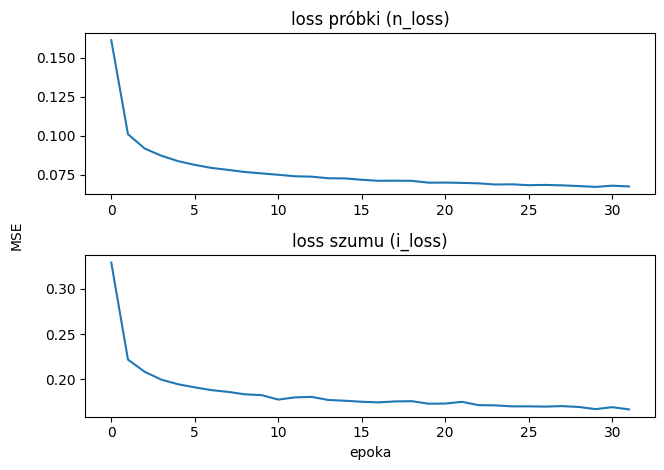

In [22]:
def plot_things(data_path):
  '''
    data will always have epoch number as its first column
  '''
  data = np.genfromtxt(data_path, dtype=float, delimiter=',', names=True)
  labels = data.dtype.names


  fig, ax = plt.subplots(len(labels) - 2, 1)
  loss_labs = ["loss próbki", "loss szumu"]
  for count, label in enumerate(labels[1:-1]):
    ax[count].set_title(loss_labs[count] + f" ({label})")
    ax[count].plot(data[label])

  plt.xlabel("epoka")
  # plt.ylabel("MSE")
  fig.text(-0.02, 0.5, 'MSE', ha='center', va='center', rotation='vertical')
  fig.tight_layout()
  return fig

path_to_csv ="sql_simple_language_model\\history.csv"
fig = plot_things(path_to_csv)